In [1]:
import numpy as np
import math # only for simple mathematical calculations
import matplotlib.pyplot as plt

In [2]:
# Loading data
train_data = np.loadtxt('./p3_train.csv', delimiter=',',skiprows=1)
test_data = np.loadtxt('./p3_test.csv', delimiter=',',skiprows=1)

In [3]:
# divide data into training and testing
X_train, y_train = train_data[:,:10], train_data[:,10]
X_test, y_test = test_data[:,:10], test_data[:,10]

In [4]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

# Implementing FLDA for the classification problem

In [5]:
# Compute the mean and covariance matrices for each class
class_means = []
for c in np.unique(y_train):
    class_means.append(np.mean(X_train[y_train == c], axis=0))

In linear discriminant analysis (LDA), the within-class scatter matrix (S_w) and the between-class scatter matrix (S_b) are used to project the data onto a lower-dimensional space while maximizing the class separability.

S_w = The within-class scatter matrix S_w measures the within-class variance of the data, i.e., the variance of the data points within each class.


S_b = The between-class scatter matrix S_b measures the between-class variance of the data, i.e., the variance between different classes

In [6]:
S_w = np.zeros((X.shape[1], X.shape[1])) # Within-class scatter matrix
for c, mean in zip(np.unique(y_train), class_means):
    X_c = X_train[y_train == c]
    S_w += np.dot((X_c - mean).T, (X_c - mean))

In [7]:
S_b = np.zeros((X.shape[1], X.shape[1])) # Between-class scatter matrix
mean_all = np.mean(X_train, axis=0)
for c, mean in zip(np.unique(y_train), class_means):
    n_c = len(X_train[y_train == c])
    S_b += n_c * np.dot((mean - mean_all).reshape(-1, 1), (mean - mean_all).reshape(1, -1))

This code computes the FLDA projection matrix W by first calculating the generalized eigenvectors and eigenvalues of the matrix product (S_w)^-1 S_b using the np.linalg.eig function. The eigenvectors are stored in eigenvectors and the corresponding eigenvalues are stored in eigenvalues.

The eigenvectors are sorted in descending order of their corresponding eigenvalues using np.argsort(eigenvalues)[::-1] and the first len(np.unique(y))-1 eigenvectors are selected as the projection matrix W. The reason for selecting the first len(np.unique(y))-1 eigenvectors is that there are len(np.unique(y)) classes in the data and the projection matrix should have num_classes - 1 columns.

Finally, the training and testing data are projected onto the FLDA space using the projection matrix W with the code X_train_lda = np.dot(X_train, W) and X_test_lda = np.dot(X_test, W)

In [8]:
# Compute the FLDA projection matrix
eigenvalues, eigenvectors = np.linalg.eig(np.dot(np.linalg.inv(S_w), S_b))
W = eigenvectors[:, np.argsort(eigenvalues)[::-1][:len(np.unique(y))-1]]

In [9]:
# Project the training and testing data onto the FLDA space
X_train_lda = np.dot(X_train, W)
X_test_lda = np.dot(X_test, W)

# This code fits a logistic regression model on the FLDA-transformed training data and predicts the labels for the FLDA-transformed testing data. It then computes the classification accuracy as the proportion of correctly classified samples in the testing data.

ERM using Multi class using logistic regressor

In [10]:
# making augmented train 
tmp = np.ones((X_train_lda.shape[0],1)) 
X_train_lda=np.column_stack((X_train_lda,tmp))
X_train_lda.shape

(60000, 5)

In [11]:
# making augmented test 
tmp = np.ones((X_test_lda.shape[0],1))
X_test_lda=np.column_stack((X_test_lda,tmp))
X_test_lda.shape

(15000, 5)

Calculating ERM on training and testing

Training

In [12]:
classes, features = 5, 5

In [13]:
# computing Weight for every class
W=[]
for i in range(5):
    W.append(np.ones((features,1)))

In [14]:
def find_loss(X,W,j):
    X=X.reshape((X.shape[0],1))
    e=[]                        # exponent e
    g = []                      # softmax g
    grad = []                   # gradient grad
    for i in range(classes):
        e.append(math.exp(W[i].T@X))
    k = sum(e)
    for i in range(classes):
        g.append(e[i]/k)
    loss = -1*math.log(g[j])     # loss for single image
    for i in range(classes):
        if i!=j:
            grad.append(-g[i]*X.reshape(X.shape[0]))
        else:
            grad.append((1-g[i])*X.reshape(X.shape[0]))
    return loss,grad

In [15]:
def training_epoch():
    final_loss = 0
    final_grad = np.zeros((features,classes))  
    for i in range(X_train_lda.shape[0]):
        loss,grad = find_loss(X_train_lda[i,:],W,int(y_train[i])-1)    
        final_loss =final_loss + loss
        final_grad = final_grad + np.stack(grad,axis = 1)
    return final_loss,final_grad

In [16]:
epochs, alpha, prev_loss = 10, 10, 0
for i in range(epochs):
    loss,grad = training_epoch()
    for j in range(classes):
        gradient = grad[:,j].reshape(grad[:,j].shape[0],1)
        if prev_loss<loss:
            alpha = (alpha/10)
        W[j]=W[j]+alpha*gradient/np.linalg.norm(gradient)
        prev_loss = loss
print(f'loss at {i+1}th i.e last epoch is {loss/X_train_lda.shape[0]}')

loss at 10th i.e last epoch is 1.1470394728747044


In [17]:
print(f'ERM on training data is: {loss/X_train_lda.shape[0]}')

ERM on training data is: 1.1470394728747044


Testing

In [18]:
confusion_matrix = np.zeros((classes,classes))
count, loss = 0, 0
for i in range(X_test_lda.shape[0]):
    X = X_test_lda[i,:]
    X=X.reshape((X.shape[0],1))
    e=[]                        # exponent
    g = []                      # softmax
    grad = []                   # gradient 
    for j in range(classes):
        e.append(math.exp(W[j].T@X))
    k = sum(e)
    for j in range(classes):
        g.append(e[j]/k)
    k = g.index(max(g))
    if k==int(y_test[i])-1:  # Class starts from 1
        count = count+1
    v = int(y_test[i])-1
    confusion_matrix[v][k] += 1

    loss = loss - 1*math.log(g[v])

In [19]:
print(f'ERM on Testing data is: {loss/X_test_lda.shape[0]}')

ERM on Testing data is: 1.1423435706588208


Accuracy using Logistic Regression

In [20]:
print(f'Classification accuracy is: {count*100/X_test_lda.shape[0]}')

Classification accuracy is: 57.17333333333333


# Confusion Matrix

A confusion matrix is used to calculate various performance metrics for the classification model, such as accuracy, precision, recall, F1 score, and others. It is a useful for evaluating the performance of a classification model and understanding how well it is able to classify the different classes.

In [21]:
print('testing data confusion matrix is:')
print(confusion_matrix)

testing data confusion matrix is:
[[1517.  388.  303.  374.  389.]
 [ 380. 1687.  302.  278.  334.]
 [ 309.  301. 1877.  261.  292.]
 [ 341.  344.  264. 1739.  287.]
 [ 354.  319.  264.  340. 1756.]]


# F1 Score

It is the harmonic mean of precision and recall, and it ranges from 0 to 1.

In [22]:
# function to calculate F1 score
def F1(classes,confusion_matrix):
    TP, TN, FP, FN, F1 = [], [], [], [], []  # True positive True negative False Positive False negative and F values
    for i in range(classes):
        TP.append(confusion_matrix[i][i])
        TN.append(np.sum(confusion_matrix)-np.sum(confusion_matrix[i,:])-np.sum(confusion_matrix[:,i])+confusion_matrix[i][i])
        FP.append(np.sum(confusion_matrix[i,:])-confusion_matrix[i][i])
        FN.append(np.sum(confusion_matrix[:,i])-confusion_matrix[i][i])
        F1.append((2*TP[i])/(2*TP[i] + FP[i] + FN[i]))
    return F1

In [23]:
score = F1(classes,confusion_matrix)
for c in range(classes):
    print(f"F1 Score Class {c}: {score[c]}")

F1 Score Class 0: 0.5166893732970027
F1 Score Class 1: 0.5604651162790698
F1 Score Class 2: 0.620495867768595
F1 Score Class 3: 0.5828724652254064
F1 Score Class 4: 0.576588409128222


# ROC Curve between any 2 classes

To plot the RoC curves for the chosen pair of classes, we can follow these steps:

1. Compute the predicted probabilities for the chosen pair of classes using the trained logistic regression model and the testing data projected onto the FLDA space.
2. Compute the true positive rate (TPR) and false positive rate (FPR) for different threshold values.
3. Plot the RoC curve using the TPR and FPR values.

In [24]:
classes = 2

In [25]:
temp = train_data[:,:]
lst = []
ans = []
for i in range(classes):
    x1 = temp[np.where(temp[:,10]==i+1)]
    x = x1[:,:10]
    y = x1[:,10]
    y=y.reshape((y.shape[0],1))
    lst.append(x)
    ans.append(y)

In [26]:
l = np.row_stack((lst[0],lst[1]))
m = np.row_stack((ans[0],ans[1]))

In [27]:
mean=[]   
for i in range(classes):
    a=lst[i]
    a = a.mean(axis=0)
    mean.append(a)

In [28]:
TPR, FPR = [], []
for j in range(20):
    count = 0
    threshold=(j-10)/100
    TP , FP, TN, FN = 0, 0, 0, 0
    for i in range(l.shape[0]):
        v = (l[i]-mean[0])
        v = np.power(v,2)
        k = 0.5 * np.sum(v)
        k1 = math.exp(-k)
        v = (l[i]-mean[1])
        v = np.power(v,2)
        k = 0.5 * np.sum(v)
        k2 = math.exp(-k)
        if k1-k2>threshold:
            k=2
        else:
            k=1
        if k==int(m[i][0]) and k==2:
            TP+=1
        elif k==int(m[i][0]) and k==1:
            TN+=1
        elif k!=int(m[i][0]) and k==2:
            FP+=1
        else:
            FN+=1
    TPR.append(TP/(TP+FN))
    FPR.append(FP/(FP+TN))
    

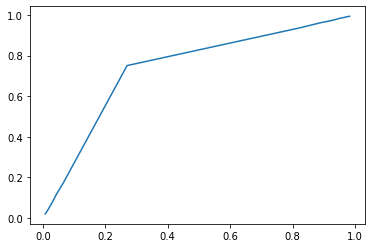

In [29]:
plt.plot(TPR,FPR)

High true positive rate (TPR) but a relatively high false positive rate (FPR) as well. This means that the classifier is able to correctly identify a large proportion of positive cases, but at the same time also incorrectly identifies a relatively large proportion of negative cases as positive. The sharp rise at the beginning of the curve may indicate that the classifier is initially very good at correctly identifying positive cases, but then reaches a limit beyond which it cannot improve further without also increasing the number of false positives.

# Likelihood curve for different number of mixtures as hyper-parameters

Performing Gaussian Mixture Model clustering on training data and then using the learned model to predict the labels of the testing data. To plot the likelihood curve for EM with different choices for the number of mixtures as hyperparameters, we will first define a function to perform EM algorithm with a given number of mixtures and compute the log-likelihood at each iteration. Then, we can call this function for different choices of the number of mixtures and plot the log-likelihood curves.

In [30]:
def multivariate_gaussian_pdf(X, mean, cov):
    N, D = X.shape
    X = X - mean
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    norm_const = 1.0 / (np.power((2*np.pi),float(D)/2) * np.power(det,1.0/2))
    exp_val = np.array([np.dot(np.dot(X[n], inv), X[n]) for n in range(N)])
    return norm_const * np.exp(-exp_val/2)

In [31]:
def em_algorithm(X, K, num_iter=100, tol=1e-4):
    N, D = X.shape
    # Initialize parameters
    pi = np.ones(K) / K
    mu = np.random.randn(K, D)
    sigma = np.array([np.eye(D) for k in range(K)])
    log_likelihoods = []
    
    # Run EM algorithm
    for i in range(num_iter):
        # E-step
        gamma = np.zeros((N, K))
        for k in range(K):
            gamma[:, k] = pi[k] * multivariate_gaussian_pdf(X, mu[k], sigma[k])
        gamma /= gamma.sum(axis=1, keepdims=True)
        
        # M-step
        N_k = gamma.sum(axis=0)
        pi = N_k / N
        for k in range(K):
            mu[k] = gamma[:, k].dot(X) / N_k[k]
            X_mu = X - mu[k]
            sigma[k] = (gamma[:, k] * X_mu.T).dot(X_mu) / N_k[k]
        
        # Compute log-likelihood
        log_likelihood = np.sum(np.log(gamma.dot(pi)))
        log_likelihoods.append(log_likelihood)
        
        # Check for convergence
        if i > 0 and np.abs(log_likelihood - log_likelihoods[i-1]) < tol:
            break
    
    return pi, mu, sigma, log_likelihoods

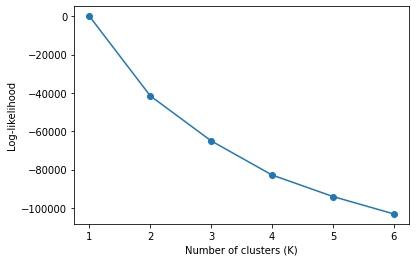

In [32]:
# Run EM algorithm on training data with different values of K
K_range = range(1, 7)
log_likelihoods_train = []
for k in K_range:
    pi, mu, sigma, log_likelihoods = em_algorithm(X_train, k)
    log_likelihoods_train.append(log_likelihoods[-1])

# Plot log-likelihood vs. K for training data
fig, ax = plt.subplots()
ax.plot(K_range, log_likelihoods_train, 'o-')
ax.set_xlabel('Number of clusters (K)')
ax.set_ylabel('Log-likelihood')
plt.show()